<a href="https://colab.research.google.com/github/arjan-hada/esm2-antibody-CLIP/blob/main/ESM2AbCLIP_bindaff_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The effect of Multimodal Training on Antibody Binding Affinity Prediction

In the [previous notebook](https://github.com/arjan-hada/esm2-antibody-CLIP/blob/main/ESM2_Ab_CLIP.ipynb), we developed a multimodal training approach that integrated antibody sequence data with structural data using a contrastive learning framework inspired by OpenAI's CLIP. We utilized the ESM2 model from Facebook's Evolutionary Scale Modeling (ESM) suite as our base architecture. The model was fine-tuned with a custom head for contrastive learning, where the sequence and structural embeddings were projected into a common latent space. Our training process focused on minimizing the contrastive loss to ensure that sequences and their corresponding structures were closely aligned in this space. We called this model ESM2-Ab-CLIP.

In this notebook we evaluate the effect of ESM2-Ab-CLIP model on antibody binding affinity prediction task relative to the base ESM2 model. We will examine the impact of finetuning both ESM2-Ab-CLIP and ESM2 models on predicting the binding affinity (Kd) between single-chain variable fragments (scFv) variants and the SARS-CoV-2 peptide. Additionally, we will explore the effect of fine-tuning both models using a subset of the training data.

## Setup

In [ ]:
# Setup block for Colab
# Install necessary libraries for the project
!pip install python-Levenshtein evaluate datasets transformers accelerate &> /dev/null
!apt install git-lfs &> /dev/null

In [ ]:
# To share your model with the community
# First store your authentication token from the Hugging Face website and then execute this cell
# Make sure to get token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Import necessary libraries
from pathlib import Path
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_context(context="paper", font_scale=1.5)

import Levenshtein

from torch.utils.data import Dataset, DataLoader, random_split
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer, set_seed
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

import datasets
from datasets import load_dataset, Dataset, DatasetDict

## Data loading and processing

We will use a dataset that consists of binding interactions for antibodies against a SARS-CoV-2 peptide detailed in the study "[Machine learning optimization of candidate antibody yields highly diverse sub-nanomolar affinity antibody libraries](https://www.nature.com/articles/s41467-023-39022-2#data-availability)". The complete raw dataset was also published separately [here](https://www.nature.com/articles/s41597-022-01779-4) and available for public access at [Zenodo](https://zenodo.org/records/7783546).  The target peptide is a conserved sequence found in the HR2 region of coronavirus spike proteins and to which neutralizing antibodies were previously identified. The full data includes four different libraries of single-chain variable fragments (scFv). In this study we will only use the AA4L49 library for Ab-14 heavy chain sequences.

The loading and preprocessing of the data were extensively detailed in our [prior notebooks](https://github.com/arjan-hada/antibody-binding-affinity/tree/main).

In [ ]:
### Step 1: Define Utility Functions
from pathlib import Path
from urllib.request import urlretrieve
import pandas as pd

def download_file(url, path):
    """Downloads and saves the file only if it does not already exist."""
    if not path.exists():
        urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"File already exists at {path}")

def load_data(paths):
    """Load data from CSV files into Pandas DataFrames."""
    return {key: pd.read_csv(path) for key, path in paths.items()}

def handle_missing_values(dfs, group_col='mata_description', target_col='pred_aff', filter_nan='drop'):
    """
    Handles missing values in a dictionary of DataFrames by either dropping them or filling them
    with the median of groups with less than 3 non-NaN entries. It processes 'train', 'valid',
    and 'test' datasets as provided in the dictionary 'dfs'.

    Parameters:
        dfs (dict): Dictionary containing the dataframes under keys 'train', 'valid', 'test'.
        group_col (str): The column to group by.
        target_col (str): The column for which the median is calculated.
        filter_nan (str): The method to handle NaN values ('drop' or 'median').
    """
    data_all = pd.concat(dfs.values())

    # Exclude sequence where all replicates contained NaN in target_col
    dfs['test'] = dfs['test'].groupby(group_col).filter(lambda x: x[target_col].notna().sum() > 0)

    if filter_nan == 'drop':
        for key, df in dfs.items():
            dfs[key] = df.dropna(subset=[target_col])
    elif filter_nan == 'median':
        # Drop NaN values and calculate medians for groups with less than 3 non-NaN entries.
        non_nan_data = data_all.dropna(subset=[target_col])
        medians = non_nan_data.groupby(group_col).filter(lambda x: len(x) < 3)[target_col].median()

        for key, df in dfs.items():
            dfs[key][target_col] = df[target_col].fillna(medians)

    return dfs

def process_replicates(dataframes, group_col='mata_description', target_col='pred_aff'):
    """Calculate mean of replicates and drop duplicates."""
    for df in dataframes.values():
        df[target_col] = df.groupby(group_col)[target_col].transform('mean')
        df.drop_duplicates(subset=[group_col], inplace=True)

def add_static_sequences(dataframes, aa_col='aa_seq', left_seq='', right_seq=''):
    """Add static sequences to amino acid sequences."""
    for df in dataframes.values():
        df['hc'] = left_seq + df[aa_col].astype(str) + right_seq

In [ ]:
### Step 2: Setup Paths and URLs
urls = {
    'train': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_train.csv',
    'valid': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_valid.csv',
    'test': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_test.csv'
}

path_data = Path('data')
path_data.mkdir(exist_ok=True)
paths = {key: path_data / f'14H_{key}.csv' for key in urls}

In [ ]:
### Step 3: Download and Load Data

for key, url in urls.items():
    download_file(url, paths[key])

df_dict = load_data(paths)

Downloaded data/14H_train.csv
Downloaded data/14H_valid.csv
Downloaded data/14H_test.csv


In [ ]:
# Information pulled out from paper for reference
wt_14VH = 'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS'
static_left = 'EVQLVETGGGLVQPGGSLRLSCAAS'
static_right = 'WGQGTLVTVSS'
mutation_window = 'GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDS'

In [ ]:
### Step 4: Data Processing
import copy
# Create deep copies of the DataFrames
dfs_copies1 = {key: df.copy() for key, df in df_dict.items()}

handle_missing_values(dfs_copies1, filter_nan='drop')
add_static_sequences(dfs_copies1, left_seq='EVQLVETGGGLVQPGGSLRLSCAAS', right_seq='WGQGTLVTVSS')

# Output processed data
for key, df in dfs_copies1.items():
    print(f"Processed data for {key}: {df.shape[0]} entries")

Processed data for train: 20547 entries
Processed data for valid: 2606 entries
Processed data for test: 2576 entries


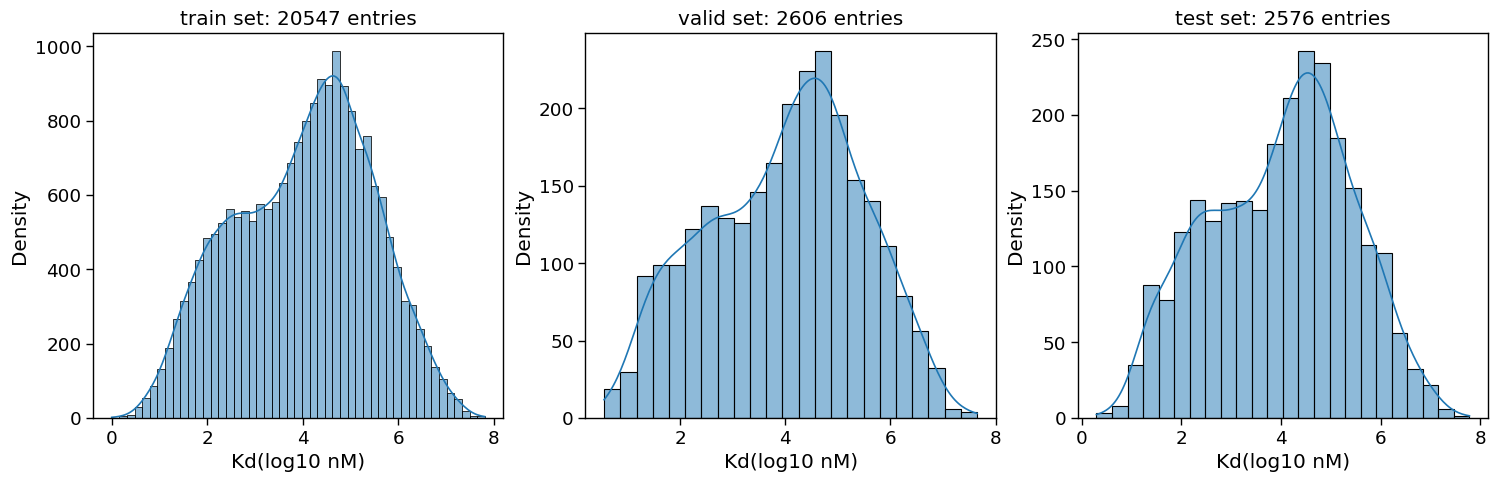

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

for i, (key, df) in enumerate(dfs_copies1.items()):
    # First scatter plot:
    plt.subplot(1, len(dfs_copies1.items()), i+1)
    sns.histplot(df['pred_aff'].values, kde=True)
    plt.xlabel('Kd(log10 nM)')
    plt.ylabel('Density')
    plt.title(f"{key} set: {df.shape[0]} entries");

## Training preparation

### Defining the performance metrics

Spearman's rank correlation coefficient is typically the go-to metric for checking how well our models perform on experimental data. However, often protein functional property measurements display a bimodal pattern. In those case, rank correlations may not be the optimal choice. Now, let's say we're designing antibodies and we really care about finding the ones with the best binding affinities. It's more important that our model identifies the top performers rather than capture the distribution of the full data. Thus, we also calculate Top K Recall, where K is set to the top 10% of the antibodies with the highest binding affinity (that's the lowest Kd values).

In [ ]:
def compute_top_10_percent_recall(predictions, labels):
    n_top = int(0.1 * len(labels))
    top_pred_indices = np.argsort(predictions)[:n_top]
    top_label_indices = np.argsort(labels)[:n_top]
    recall = len(set(top_pred_indices).intersection(set(top_label_indices))) / n_top

    return {
        "top_10_percent_recall": recall
    }


from evaluate import load
import numpy as np

metric_spearmanr = load("spearmanr")

def compute_metrics(eval_pred):
    """
    Compute Spearman's rank correlation coefficient and top 10% recall between
    the predicted and actual labels.
    """
    predictions, labels = eval_pred
    predictions = np.squeeze(predictions)
    labels = np.squeeze(labels)
    spearmanr_result = metric_spearmanr.compute(predictions=predictions, references=labels)
    top_10_percent_recall_result = compute_top_10_percent_recall(predictions, labels)
    return {**spearmanr_result, **top_10_percent_recall_result}

### Tokenizer, Dataset, Trainer

For quicker iteration we will create some functions to try different pretrained models and trainer parameters.

In [ ]:
def tok_func(example, tokenizer, inp_col):
    """
    Tokenizes input data using a predefined tokenizer.
    `Dataset.map` needs this function.
    """
    # a dictionary containing 'input_ids' and other tensors like 'attention_mask'
    return tokenizer(example[inp_col], return_tensors='pt')

In [ ]:
def get_tok_dds(df_dict, tokenizer, inp_col, label_col, sample_frac=None):
    """
    Converts a dictionary of pandas DataFrames to a Hugging Face DatasetDict
    and tokenizes it. Optionally sample a fraction of train set.
    """

    # convert pandas DataFrames into HuggingFace Datasets
    # rename the labels column to what Transformers expects for the dependent variable, which is labels
    dds = {}
    for key, df in df_dict.items():
        ds = Dataset.from_pandas(df).rename_column(label_col, 'labels')
        dds[key] = ds

    dds = DatasetDict(dds)

    # Optionally sample a fraction of the training data
    if sample_frac and 'train' in dds:
        seed = 42
        num_samples = int(sample_frac * len(dds['train']))
        dds['train'] = dds['train'].shuffle(seed=seed).select(range(num_samples))

    fields = list(dds['train'].column_names)
    fields.remove('labels') # list containing the columns we no longer need

    # tokenize the input, use batching to speed it up, and remove the columns we no longer need
    tok_dds = dds.map(lambda x: tok_func(x, tokenizer, inp_col),
                      batched=True,
                      remove_columns=fields)
    return tok_dds

In [ ]:
def get_trainer(tok_dds, model, tokenizer, model_name='outputs',
                lr=2e-5, bs=32, epochs=5, wd=0.01):
    """
    Returns a Hugging Face Trainer instance with specified training arguments and datasets.
    """
    set_seed(42)
    args = TrainingArguments(
        output_dir=model_name,
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs * 2,
        num_train_epochs=epochs,
        weight_decay=wd,
        fp16=True, # much faster on modern GPUs and saves some memory
        warmup_ratio=0.1,
        lr_scheduler_type="cosine", # cosine scheduler with warmup
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model='spearmanr',
        greater_is_better=True,
        push_to_hub=False,
    )
    return Trainer(model, args, train_dataset=tok_dds['train'],
                   eval_dataset=tok_dds['valid'], tokenizer=tokenizer,
                   compute_metrics=compute_metrics)

In [ ]:
import gc # Python's garbage collection module

def clear_memory():
    gc.collect() # explicitly triggers garbage collection, free up memory
    if torch.cuda.is_available(): torch.cuda.empty_cache() # clears the PyTorch CUDA memory cache

## Training - 100% of training data

### Training with unimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'facebook/esm2_t6_8M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model_esm2 = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)

tok_dds = get_tok_dds(dfs_copies1, tokz, inp_col='hc', label_col='pred_aff')

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20547 [00:00<?, ? examples/s]

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_unimodal = get_trainer(tok_dds, model_esm2, tokz,
                      model_name=f"{model_name}-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_unimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,7.004300,1.754906,0.596948,0.415385
2,1.565100,1.411557,0.627606,0.500000
3,1.297100,1.217198,0.642230,0.515385
4,1.169800,1.169308,0.645795,0.550000
5,1.117800,1.160396,0.647910,0.557692


TrainOutput(global_step=3215, training_loss=2.1537375680024664, metrics={'train_runtime': 128.8377, 'train_samples_per_second': 797.399, 'train_steps_per_second': 24.954, 'total_flos': 554884539890400.0, 'train_loss': 2.1537375680024664, 'epoch': 5.0})

In [ ]:
# Make predictions on the test set
trainer_unimodal.evaluate(eval_dataset=tok_dds['test'])

{'eval_loss': 1.1752053499221802,
 'eval_spearmanr': 0.6215261011489414,
 'eval_top_10_percent_recall': 0.4396887159533074,
 'eval_runtime': 0.9088,
 'eval_samples_per_second': 2834.593,
 'eval_steps_per_second': 45.116,
 'epoch': 5.0}

### Training with multimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0'
tokz = AutoTokenizer.from_pretrained(model_ckpt, trust_remote_code=True)
model_esm2abclip = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           trust_remote_code=True,
                                                           num_labels=1)

#tok_dds = get_tok_dds(dfs_copies1, tokz, inp_col='hc', label_col='pred_aff')

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.7M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_multimodal = get_trainer(tok_dds, model_esm2abclip, tokz,
                      model_name=f"{model_name}-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_multimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,6.898000,1.358448,0.596090,0.415385
2,1.435500,1.224054,0.637579,0.553846
3,1.255000,1.186020,0.647280,0.569231
4,1.142400,1.147836,0.651151,0.565385
5,1.097800,1.143114,0.652217,0.580769


TrainOutput(global_step=3215, training_loss=2.0959843613311624, metrics={'train_runtime': 128.0585, 'train_samples_per_second': 802.251, 'train_steps_per_second': 25.106, 'total_flos': 554884539890400.0, 'train_loss': 2.0959843613311624, 'epoch': 5.0})

In [ ]:
# Make predictions on the test set
trainer_multimodal.evaluate(eval_dataset=tok_dds['test'])

{'eval_loss': 1.174391269683838,
 'eval_spearmanr': 0.621920835635743,
 'eval_top_10_percent_recall': 0.46303501945525294,
 'eval_runtime': 0.9138,
 'eval_samples_per_second': 2818.919,
 'eval_steps_per_second': 44.866,
 'epoch': 5.0}

## Training - low data regime (20% of training data)

### Training with unimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'facebook/esm2_t6_8M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model_esm2 = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)
tok_dds_subset = get_tok_dds(dfs_copies1, tokz, inp_col='hc',
                             label_col='pred_aff', sample_frac=0.2)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4109 [00:00<?, ? examples/s]

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_unimodal = get_trainer(tok_dds_subset, model_esm2, tokz,
                      model_name=f"{model_name}-lowN-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_unimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,No log,5.468854,-0.253146,0.007692
2,No log,2.227622,0.026983,0.084615
3,No log,1.991670,0.465015,0.269231
4,4.792700,1.810585,0.487901,0.292308
5,4.792700,1.734225,0.516974,0.273077


TrainOutput(global_step=645, training_loss=4.106281747744065, metrics={'train_runtime': 30.4577, 'train_samples_per_second': 674.542, 'train_steps_per_second': 21.177, 'total_flos': 110966105728800.0, 'train_loss': 4.106281747744065, 'epoch': 5.0})

In [ ]:
# Make predictions on the test set
trainer_unimodal.evaluate(eval_dataset=tok_dds_subset['test'])

{'eval_loss': 1.639440655708313,
 'eval_spearmanr': 0.5123443628631299,
 'eval_top_10_percent_recall': 0.26459143968871596,
 'eval_runtime': 0.9252,
 'eval_samples_per_second': 2784.292,
 'eval_steps_per_second': 44.315,
 'epoch': 5.0}

### Training with multimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0'
tokz = AutoTokenizer.from_pretrained(model_ckpt, trust_remote_code=True)
model_esm2abclip = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           trust_remote_code=True,
                                                           num_labels=1)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_multimodal = get_trainer(tok_dds_subset, model_esm2abclip, tokz,
                      model_name=f"{model_name}-lowN-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_multimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,No log,5.454203,-0.166815,0.061538
2,No log,2.206940,0.011645,0.100000
3,No log,1.861360,0.502974,0.238462
4,4.617900,1.756204,0.508748,0.346154
5,4.617900,1.593818,0.553668,0.357692


TrainOutput(global_step=645, training_loss=3.9303875117338904, metrics={'train_runtime': 31.1122, 'train_samples_per_second': 660.352, 'train_steps_per_second': 20.731, 'total_flos': 110966105728800.0, 'train_loss': 3.9303875117338904, 'epoch': 5.0})

In [ ]:
# Make predictions on the test set
trainer_multimodal.evaluate(eval_dataset=tok_dds_subset['test'])

{'eval_loss': 1.5352743864059448,
 'eval_spearmanr': 0.5404960802322395,
 'eval_top_10_percent_recall': 0.29961089494163423,
 'eval_runtime': 0.9275,
 'eval_samples_per_second': 2777.383,
 'eval_steps_per_second': 44.205,
 'epoch': 5.0}

## Training - low data regime (40% of training data)

### Training with unimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'facebook/esm2_t6_8M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model_esm2 = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)
tok_dds_subset = get_tok_dds(dfs_copies1, tokz, inp_col='hc',
                             label_col='pred_aff', sample_frac=0.4)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8218 [00:00<?, ? examples/s]

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_unimodal = get_trainer(tok_dds_subset, model_esm2, tokz,
                      model_name=f"{model_name}-lowN-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_unimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,No log,2.333753,-0.136400,0.096154
2,5.481900,1.940855,0.517497,0.273077
3,5.481900,1.351192,0.606836,0.438462
4,1.459400,1.305599,0.614805,0.484615
5,1.459400,1.296961,0.613757,0.484615


TrainOutput(global_step=1285, training_loss=2.9766054383511675, metrics={'train_runtime': 55.542, 'train_samples_per_second': 739.801, 'train_steps_per_second': 23.136, 'total_flos': 221932211457600.0, 'train_loss': 2.9766054383511675, 'epoch': 5.0})

In [ ]:
trainer_unimodal.evaluate(eval_dataset=tok_dds['test'])

{'eval_loss': 1.2994182109832764,
 'eval_spearmanr': 0.5875547025282839,
 'eval_top_10_percent_recall': 0.3852140077821012,
 'eval_runtime': 0.9198,
 'eval_samples_per_second': 2800.63,
 'eval_steps_per_second': 44.575,
 'epoch': 5.0}

### Training with multimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0'
tokz = AutoTokenizer.from_pretrained(model_ckpt, trust_remote_code=True)
model_esm2abclip = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           trust_remote_code=True,
                                                           num_labels=1)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_multimodal = get_trainer(tok_dds_subset, model_esm2abclip, tokz,
                      model_name=f"{model_name}-lowN-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_multimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,No log,2.307513,-0.098747,0.076923
2,5.292200,1.503850,0.548991,0.411538
3,5.292200,1.351237,0.615636,0.484615
4,1.355400,1.270522,0.618094,0.519231
5,1.355400,1.264566,0.615282,0.503846


TrainOutput(global_step=1285, training_loss=2.853902165156858, metrics={'train_runtime': 55.56, 'train_samples_per_second': 739.561, 'train_steps_per_second': 23.128, 'total_flos': 221932211457600.0, 'train_loss': 2.853902165156858, 'epoch': 5.0})

In [ ]:
trainer_multimodal.evaluate(eval_dataset=tok_dds_subset['test'])

{'eval_loss': 1.2605490684509277,
 'eval_spearmanr': 0.5997461566065982,
 'eval_top_10_percent_recall': 0.41245136186770426,
 'eval_runtime': 0.9138,
 'eval_samples_per_second': 2819.078,
 'eval_steps_per_second': 44.869,
 'epoch': 5.0}


## Training - low data regime (80% of training data)



### Training with unimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'facebook/esm2_t6_8M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model_esm2 = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)
tok_dds_subset = get_tok_dds(dfs_copies1, tokz, inp_col='hc',
                             label_col='pred_aff', sample_frac=0.8)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16437 [00:00<?, ? examples/s]

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_unimodal = get_trainer(tok_dds_subset, model_esm2, tokz,
                      model_name=f"{model_name}-lowN-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_unimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,6.664400,1.960567,0.557742,0.350000
2,1.512900,1.285010,0.621505,0.507692
3,1.292200,1.203498,0.635783,0.500000
4,1.165100,1.202079,0.638239,0.550000
5,1.114800,1.182100,0.640925,0.534615


TrainOutput(global_step=2570, training_loss=2.316726954716189, metrics={'train_runtime': 107.2877, 'train_samples_per_second': 766.024, 'train_steps_per_second': 23.954, 'total_flos': 443891428538400.0, 'train_loss': 2.316726954716189, 'epoch': 5.0})

In [ ]:
trainer_unimodal.evaluate(eval_dataset=tok_dds['test'])

{'eval_loss': 1.1657946109771729,
 'eval_spearmanr': 0.623370082549147,
 'eval_top_10_percent_recall': 0.4357976653696498,
 'eval_runtime': 0.93,
 'eval_samples_per_second': 2770.04,
 'eval_steps_per_second': 44.088,
 'epoch': 5.0}

### Training with multimodal ESM2

In [ ]:
clear_memory()

model_ckpt = 'arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0'
tokz = AutoTokenizer.from_pretrained(model_ckpt, trust_remote_code=True)
model_esm2abclip = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           trust_remote_code=True,
                                                           num_labels=1)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at arjan-hada/esm2_t6_8M_UR50D-Ab-CLIP-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_ckpt.split("/")[-1]
trainer_multimodal = get_trainer(tok_dds_subset, model_esm2abclip, tokz,
                      model_name=f"{model_name}-lowN-finetuned-Ab14H-v0",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer_multimodal.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Spearmanr,Top 10 Percent Recall
1,6.439100,1.703930,0.588933,0.430769
2,1.406900,1.301936,0.635269,0.546154
3,1.265100,1.204022,0.634804,0.546154
4,1.148800,1.192737,0.639226,0.573077
5,1.104800,1.175626,0.641628,0.573077


TrainOutput(global_step=2570, training_loss=2.2415909644694643, metrics={'train_runtime': 105.7149, 'train_samples_per_second': 777.421, 'train_steps_per_second': 24.311, 'total_flos': 443891428538400.0, 'train_loss': 2.2415909644694643, 'epoch': 5.0})

In [ ]:
trainer_multimodal.evaluate(eval_dataset=tok_dds_subset['test'])

{'eval_loss': 1.1645841598510742,
 'eval_spearmanr': 0.6259311895431643,
 'eval_top_10_percent_recall': 0.4591439688715953,
 'eval_runtime': 0.9145,
 'eval_samples_per_second': 2816.856,
 'eval_steps_per_second': 44.833,
 'epoch': 5.0}

## Conclusion

In this study, we evaluated the downstream effect of multimodal training on the ESM2 model using the CLIP procedure, resulting in the ESM2AbCLIP model. Our primary focus was on predicting the binding affinity (Kd) between single-chain variable fragments (scFv) variants and the SARS-CoV-2 peptide.

When fine-tuned on the full training dataset containing 20,547 entries, the performance of the ESM2AbCLIP model was comparable to that of the base ESM2 model. Specifically, the Spearman's rho and top 10% recall on the test set were nearly identical, indicating that with ample data for fine-tuning, the additional benefits of multimodal training may not be as pronounced. However, the true strength of the ESM2AbCLIP model emerged under a low data regime, where it consistently outperformed the unimodal approach, particularly at 20% and 40% of the training data, demonstrating its advantage in scenarios with limited data availability.

**Effect on Top 10% Recall**

| % of Train Data | Unimodal | Multimodal |
|-----------------|----------|------------|
| 20%             | 0.2646   | 0.2996     |
| 40%             | 0.3852   | 0.4125     |
| 80%             | 0.4358   | 0.4591     |
| 100%            | 0.4397   | 0.4630     |

**Effect on Spearman's r**

| % of Train Data | Unimodal | Multimodal |
|-----------------|----------|------------|
| 20%             | 0.5123   | 0.5405     |
| 40%             | 0.5876   | 0.5997     |
| 80%             | 0.6234   | 0.6259     |
| 100%            | 0.6215   | 0.6219     |


Interestingly, both models exceeded the Spearman's rho (~0.50) reported in the [original study](https://www.nature.com/articles/s41467-023-39022-2), showcasing the robustness of our approach.